# Microwave Radiometer Temperature and Humidity Retrieval

to do: introduce retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import xarray as xr
import seaborn as sns

import pyOptimalEstimation as pyOE
import pamtra2

import nonScatMWRadTran

In [4]:
%%time
nonScatMWRadTran.doTests()

CPU times: user 7.18 ms, sys: 109 µs, total: 7.29 ms
Wall time: 7.37 ms


In [5]:
prior = xr.open_dataset('radiosonde_climatology_nsa.nc')
prior = prior.dropna('time',how='all')
prior

<xarray.Dataset>
Dimensions:   (height: 332, time: 21174)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2018-01-08T18:00:00
  * height    (height) float32 0.008 0.028 0.048 ... 40.008007 40.508007
Data variables:
    temp      (time, height) float32 -11.4468975 -9.360643 ... nan nan
    rh        (time, height) float32 74.25851 67.062645 72.01327 ... nan nan nan
    bar_pres  (time, height) float32 101.90272 101.88716 101.62322 ... nan nan
    dp        (time, height) float32 -14.990514 -14.00249 -13.726094 ... nan nan

In [6]:
prior['height'] = prior.height*1000
prior['temp'] = prior.temp+273.15
prior['bar_pres'] = prior.bar_pres*1000
prior['rh'] = prior.rh/100
prior['tpot'] = pamtra2.libs.meteo_si.temperature.T_pot(prior['temp'],prior['bar_pres'])

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(array([1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 4.000e+00,
        6.000e+00, 5.000e+00, 8.000e+00, 7.000e+00, 1.400e+01, 9.000e+00,
        1.300e+01, 1.250e+02, 1.456e+03, 1.334e+03, 1.283e+03, 1.433e+03,
        1.526e+03, 1.666e+03, 1.668e+03, 1.707e+03, 1.703e+03, 1.391e+03,
        1.053e+03, 8.350e+02, 6.910e+02, 4.530e+02, 3.110e+02, 1.820e+02,
        1.120e+02, 7.400e+01, 4.700e+01, 2.800e+01, 2.400e+01, 1.800e+01,
        8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00]),
 array([-20.        , -18.57142857, -17.14285714, -15.71428571,
        -14.28571429, -12.85714286, -11.42857143, -10.        ,
         -8.57142857,  -7.14285714,  -5.71428571,  -4.28571429,
         -2.85714286,  -1.42857143,   0.        ,   1.42857143,
          2.85714286,   4.28571429,   5.71428571,   7.14285714,
          8.57142857,  10.        ,  11.42857143,  12.85714286,
   

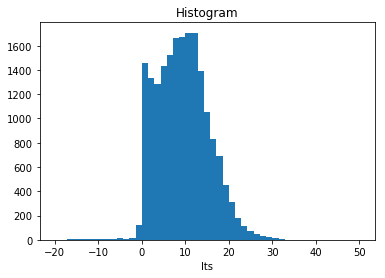

In [7]:
prior['lts'] = prior['tpot'] - prior['tpot'][:,0]
level_925 = np.nanargmin(np.abs(prior.bar_pres.mean('time').values - 92500))
prior['lts'][:,level_925].plot.hist(bins=np.linspace(-20,50).tolist())


In [8]:
# remove outliers
II = np.where(~((prior['temp'].diff('height') >11).any('height')))[0]

prior = prior.isel(time=II)
# prior['lts'][:,level_925].plot.hist(bins=np.linspace(-50,50).tolist())

In [8]:
Tnull = -273.15  # degC absolute zero
Mwml = 0.622  # no dim, Molmassenverhaeltnis

def e_sat_gg_water(T):
    """
    Calculates the saturation pressure over water after "Guide to
    Meteorological Instruments and Methods of Observation" (CIMO Guide)
    (WMO, 2008).

    Parameters
    ----------
    T:
        Temperature in K

    Returns
    -------

    float :
        saturation pressure [Pa]

    """
    T = T + Tnull
    e_sat_gg_water = 100 * 6.112 * np.exp(17.62 * T / (243.12 + T))
    return e_sat_gg_water

def e2q(e, p):
    """
    Calculate the specific humidity from vapor pressure and air
    pressure.

    Parameters
    ----------
    e:
        vapor pressure [Pa]
    p:
        pressure [Pa]

    Returns
    -------

    float :
        specific humidity [kg / kg]

    """
    q = Mwml * e / (p - (1 - Mwml) * e)
    return q

def rh2q(rh, T, p, e_sat_func=e_sat_gg_water):
    """
    Calculate the specific humidity from relative humidity, air temperature,
    and pressure.

    Parameters
    ----------
    rh:
        Relative humidity in Pa / Pa
    T:
        Temperature in K
    p:
        pressure [Pa]
    e_sat_func: func, optional
        Function to estimate the saturation pressure. E.g. e_sat_gg_water for
        water and e_sat_gg_ice for ice.

    Returns
    -------

    float :
        specific humidity [kg / kg]

    """

    eStar = e_sat_func(T)
    e = rh*eStar
    q = e2q(e, p)
    del e, eStar
    return q


prior['q'] = rh2q(prior.rh, prior.temp, prior.bar_pres)*1000

In [ ]:
hh = list(range(0,300,5))

prior = prior.isel(height=hh)

In [13]:
priors = {
    'all':prior
}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]
months = (
    [12,1,2],
[3,4,5],
[6,7,8],
[9,10,11],
         )
for season, month in zip(seasons, months):
    priors[season] = prior.where(np.in1d(prior['time.month'], month)[:,np.newaxis]).dropna('time',how='all')


    
    

# Profile
radiosonde at Barrow at 2004-03-16T12:00:00

In [9]:
profileII =2062
profile = prior.isel(time=profileII)
prior = prior.drop(labels = profile.time.values, dim='time')
nProf = len(prior.height)

#46

In [11]:
prior.mean('time')

<xarray.Dataset>
Dimensions:   (height: 60)
Coordinates:
  * height    (height) float32 8.0 107.99999 207.99997 ... 20008.008 22508.008
Data variables:
    temp      (height) float32 263.5594 264.0125 ... 222.66278 223.4231
    rh        (height) float32 0.8276393 0.8384922 ... 0.011498097 0.007498656
    bar_pres  (height) float32 101407.45 100186.95 ... 5409.9727 3738.7139
    dp        (height) float32 -11.860255 -11.259714 ... -82.95213 -82.3405
    tpot      (height) float64 262.7 263.9 265.2 266.6 ... 490.6 512.4 571.4
    lts       (height) float64 0.0 1.161 2.484 3.901 ... 206.9 227.5 248.6 304.9
    q         (height) float32 2.2305312 2.2191882 ... 0.008373815 0.008944551

In [10]:
profile

<xarray.Dataset>
Dimensions:   (height: 60)
Coordinates:
    time      datetime64[ns] 2004-03-16T12:00:00
  * height    (height) float32 8.0 107.99999 207.99997 ... 20008.008 22508.008
Data variables:
    temp      (height) float32 248.2671 247.59814 ... 224.24615 225.66922
    rh        (height) float32 0.7390142 0.7645809 ... 0.014925431 0.008370675
    bar_pres  (height) float32 101501.945 100113.92 ... 5120.2334 3501.3174
    dp        (height) float32 -27.954275 -28.15664 ... -79.457756 -78.22891
    tpot      (height) float64 247.2 247.5 251.8 257.3 ... 499.5 524.0 587.8
    lts       (height) float64 0.0 0.3054 4.583 10.12 ... 252.3 276.8 340.6
    q         (height) float32 0.37132663 0.36668596 ... 0.013114893 0.012627989

In [12]:
# #fix nans...
# prior_mean = prior.groupby('time.month').mean('time')
# for k in profile.keys():
#     profile[k].values[np.isnan(profile[k])] = prior_mean[k].values[np.isnan(profile[k])]

In [14]:
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q'%(i) for i in  prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t'%(i) for i in  prior_t.columns]
    prior_qts[season] = pn.concat((prior_q,prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(sorted(prior_qts[season].columns), axis=1)
    
prior_qts

{'all':                       00008_q     00008_t   00107_q     00107_t   00207_q  \
 time                                                                        
 2002-04-29 00:00:00  1.160764  261.703094  1.319746  262.642944  1.321661   
 2002-04-29 06:00:00  1.062880  260.471436  1.293870  261.733887  1.305203   
 2002-04-29 12:00:00  0.972103  259.239807  1.078215  259.375885  1.113145   
 2002-04-29 18:00:00  0.888014  258.008148  0.894936  257.017883  0.946762   
 2002-04-30 00:00:00  1.144730  261.549988  0.947835  260.049225  0.940483   
 2002-04-30 06:00:00  1.144730  261.549988  0.740441  256.795776  0.700379   
 2002-04-30 12:00:00  1.144730  261.549988  0.573701  253.542343  0.516439   
 2002-04-30 18:00:00  1.144730  261.549988  0.440731  250.288895  0.376751   
 2002-05-01 00:00:00  1.144730  261.549988  0.368964  248.122696  0.303982   
 2002-05-01 06:00:00  1.144730  261.549988  0.488012  251.274063  0.420020   
 2002-05-01 12:00:00  1.144730  261.549988  0.640432  254

In [106]:
maxHH = len(prior.height)
x_cov = []
x_mean = []
upper_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].iloc[:,:maxHH*2].cov()
    x_mean1 = prior_qts[season].iloc[:,:maxHH*2].mean()
    upper_mean1 = prior_qts[season].iloc[:,maxHH*2:].mean()
    
    x_cov1 = x_cov1.rename_axis('height', axis=0).rename_axis('height_T',axis=1)
    x_mean1 = x_mean1.rename_axis('height', axis=0)
    upper_mean1 = upper_mean1.rename_axis('height', axis=0)
    upper_mean1 = upper_mean1[np.where(np.isfinite(upper_mean1))[0]]

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))
    upper_mean.append(xr.DataArray(upper_mean1))



x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')
upper_mean = xr.concat(upper_mean, dim='season')


x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons
upper_mean['season'] = ['all'] + seasons


Make sure prior Sa is not singular

In [107]:
for season in x_cov.season:
    print(np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()),  x_cov.shape[-1])
    assert np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]
    
    
    

120 120
120 120
120 120
120 120
120 120


In [ ]:

def splitTQ(x):
    t_index = [i for i in x.index if i.endswith('t')]
    q_index = [i for i in x.index if i.endswith('q')]
    h_index = [float(i.split('_')[0]) for i in x.index if i.endswith('q')]

    assert len(t_index) == len(q_index)
    assert len(t_index) == len(h_index)
    assert len(t_index)*2 == len(x)


    xt = x[t_index]
    xt.index = h_index

    xq = x[q_index]
    xq.index = h_index
    
    xt.index.name = 'height'
    xq.index.name = 'height'
    
    return xt, xq

Text(0.5, 0, 'Specific Humidity [g/kg]')

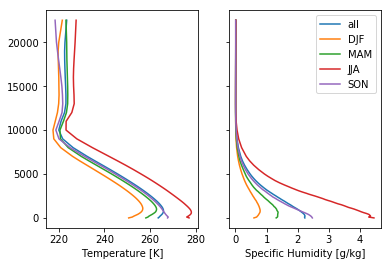

In [179]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
for season in ['all'] +seasons:
    t,q = splitTQ(x_mean.sel(season=season).to_pandas())
    ax1.plot( t, t.index,label=season)
    ax2.plot( q, q.index,label=season)

ax2.legend()
ax1.set_xlabel('Temperature [K]')
ax2.set_xlabel('Specific Humidity [g/kg]')

In [110]:
profile_t = profile['temp'].to_pandas()
profile_t.index = ['%05i_t'%(i) for i in  profile_t.index]
profile_q = profile['q'].to_pandas()
profile_q.index = ['%05i_q'%(i) for i in  profile_q.index]

x_truth = pn.concat((profile_t,profile_q))
x_truth = x_truth.reindex(sorted(x_truth.index), axis=0)

assert np.all(np.isfinite(x_truth))

# forward operator

In [188]:
def q2a(q, p, T):
    Rair = 287.04  # J/kg/K
    Rvapor = 461.5  # J/kg/K
    rho = p / (Rair * T * (1 + (Rvapor / Rair - 1) * q)) #density kg/m3
    return q*rho


def forwardRT(X,  pressure=None, zenithAngle=0, frequencies=[]):
    
    temperature, humidity = splitTQ(X)
    heights = temperature.index
    
    assert np.all(np.diff(heights)>0)
    
    abs_humidity = q2a(humidity/1000., pressure, temperature)
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m] states grid of T_final [K], p_final [Pa], q_final [kgm^-3]
        temperature ,
        pressure ,
        abs_humidity,
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

frequencies = [22.24 , 23.04, 23.84, 25.44, 26.24, 27.84, 31.4 , 51.26, 52.28, 53.86,
       54.94, 56.66, 57.3 , 58. ]


def plotResults(oe1, title=None, oe2=None, h=None, hlabel='Height [m]'):
    
    if oe2 is None:
        gridspec = dict(wspace=0.0)        
        fig, (axA,axB) = plt.subplots(ncols=2, sharey=True, gridspec_kw=gridspec, figsize = [5.0, 4.0])
        vals = [oe1], [axA], [axB]
    else:
        
        gridspec = dict(wspace=0.0, width_ratios=[1, 1, 0.25, 1, 1])        
        fig, (axA,axB, ax0, axC, axD) = plt.subplots(ncols=5, sharey=True, figsize = [10.0, 4.0], gridspec_kw=gridspec)
        vals = [oe1, oe2], [axA,axC], [axB, axD]
        ax0.set_visible(False)

        
    for oe, ax1, ax2 in zip(*vals):
        
        t_op, q_op = splitTQ(oe.x_op)
        t_op_err, q_op_err = splitTQ(oe.x_op_err)
        t_a, q_a = splitTQ(oe.x_a)
        t_a_err, q_a_err = splitTQ(oe.x_a_err)
        t_truth, q_truth = splitTQ(oe.x_truth)

        nProf = len(t_op)

        if h is None:
            hvar = t_op.index
        else:
            hvar = h
            
        ax1.plot(t_op, hvar, color='C0', label='Optimal')
        ax1.fill_betweenx(hvar,t_op+t_op_err,t_op-t_op_err,
                        color='C0', alpha=0.2)

        ax1.plot(t_a, hvar, color='C1', label='Prior')
        ax1.fill_betweenx(hvar,t_a+t_a_err,t_a-t_a_err,
                        color='C1', alpha=0.2)
        ax1.plot(t_truth, hvar, color='C2', label='Truth')

        ax2.plot(q_op, hvar, color='C0')
        ax2.fill_betweenx(hvar,q_op+q_op_err,q_op-q_op_err,
                        color='C0', alpha=0.2)

        ax2.plot(q_a, hvar, color='C1')
        ax2.fill_betweenx(hvar,q_a+q_a_err,q_a-q_a_err,
                        color='C1', alpha=0.2)
        ax2.plot(q_truth, hvar, color='C2')


        ax1.set_xlabel('Temperature [K]')
        ax2.set_xlabel('Specific humidity [g/kg]')
    if h is not None:
        axA.invert_yaxis()    

    axA.set_ylabel(hlabel)

    axA.legend(loc='upper right')
    
    fig.suptitle(title)
    return fig



# Run retrieval

In [194]:
y_vars = frequencies
x_vars = x_mean.height.values
x_ap = x_mean.sel(season='DJF').to_pandas()
x_cov1 = x_cov.sel(season='DJF').to_pandas()
y_obs = forwardRT(x_truth, pressure=profile.bar_pres.values, frequencies=frequencies)
y_obs = pn.Series(y_obs,index=y_vars)
assert np.all(np.isfinite(y_obs))
y_noise = pn.Series([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7, 0.5, 0.5, 0.3, 0.3, 0.3],index=y_vars)
y_cov = pn.DataFrame(
            np.diag(y_noise.values**2),
            index=y_vars,
            columns=y_vars,
        )
pressure = priors['DJF'].bar_pres.mean('time')
forwardKwArgs = dict(
    pressure=pressure,
    zenithAngle=0,
    frequencies=frequencies)

b_vars = []
b_param = []
b_cov = [[]]

## reference

The reference run using a prior based on December, January and February radiosondes. 

3.00 s, iteration 1, degrees of freedom: 3.96 of 120. convergence criteria fullfilled  0.004
4.56 s, iteration 2, degrees of freedom: 3.96 of 120.  Done.  0.000
[2.595635811070581, 0.09986909851460678]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


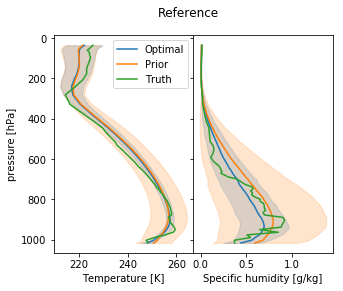

In [195]:
oe_ref = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    x_cov.sel(season='DJF').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)

oe_ref.doRetrieval()

plotResults(oe_ref, h=pressure/100, hlabel ='pressure [hPa]', title='Reference')


print([np.sqrt(np.mean((a-b)**2)) for a,b in zip(splitTQ(oe_ref.x_op), splitTQ(oe_ref.x_truth))])
print(oe_ref.chiSquareTest()[0])


## all seasons for prior
Use prior based on all seasons

3.30 s, iteration 1, degrees of freedom: 4.22 of 120. convergence criteria NOT fullfilled  1.740
4.97 s, iteration 2, degrees of freedom: 4.22 of 120. convergence criteria fullfilled  0.000
6.46 s, iteration 3, degrees of freedom: 4.22 of 120.  Done.  0.000
RMS [2.440167190436572, 0.09627307361712595]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool


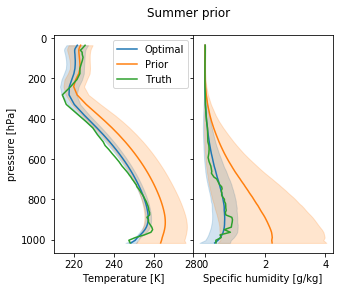

In [196]:
oe_all = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='all').to_pandas(),
    x_cov.sel(season='all').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_all.doRetrieval()

plotResults(oe_all, h=pressure/100, hlabel ='pressure [hPa]', title='Summer prior')
print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(splitTQ(oe_all.x_op), splitTQ(oe_all.x_truth))])
print(oe_all.chiSquareTest()[0])



## summer

Use summer prior instead of winter

3.07 s, iteration 1, degrees of freedom: 4.08 of 120. convergence criteria NOT fullfilled  6.416
4.60 s, iteration 2, degrees of freedom: 3.97 of 120. convergence criteria fullfilled  1.269
6.40 s, iteration 3, degrees of freedom: 3.97 of 120.  Done.  0.001
RMS [5.3318046356571465, 0.41343753501090663]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


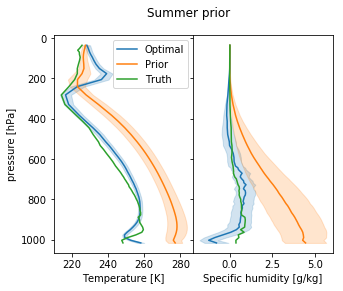

In [197]:
oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='JJA').to_pandas(),
    x_cov.sel(season='JJA').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_sum.doRetrieval()

plotResults(oe_sum, h=pressure/100, hlabel ='pressure [hPa]', title='Summer prior')

print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(splitTQ(oe_sum.x_op), splitTQ(oe_sum.x_truth))])
print(oe_sum.chiSquareTest()[0])






## diagonal prior

3.34 s, iteration 1, degrees of freedom: 3.29 of 120. convergence criteria fullfilled  0.010
5.34 s, iteration 2, degrees of freedom: 3.29 of 120.  Done.  0.000
RMS [2.7373296296613323, 0.11004156229379755]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


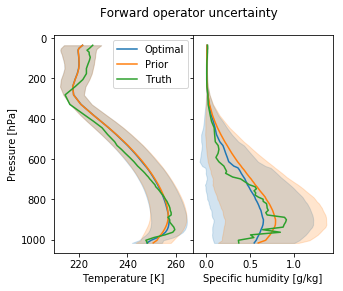

In [203]:
oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    np.diag(np.diag(x_cov.sel(season='DJF'))),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_diag.doRetrieval()



plotResults(oe_diag, h=pressure/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(splitTQ(oe_diag.x_op), splitTQ(oe_diag.x_truth))])
print(oe_diag.chiSquareTest()[0])


## Forward operator uncertainty

Add errors of D. Cimini's study:

In [198]:
Syb = pn.DataFrame(np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
]),
                  index=frequencies[::-1],
                  columns=frequencies)

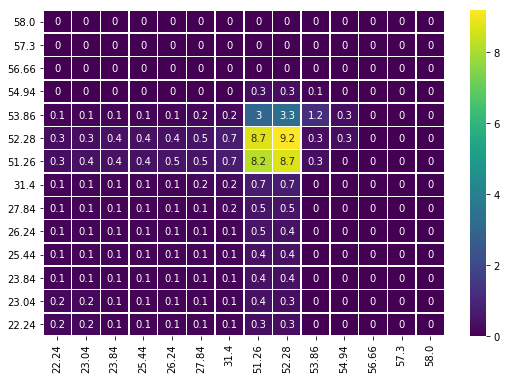

In [199]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Syb, annot=True, linewidths=.5, ax=ax, fmt = 'g',
                   cmap='viridis')

3.90 s, iteration 1, degrees of freedom: 3.48 of 120. convergence criteria fullfilled  0.005
5.65 s, iteration 2, degrees of freedom: 3.48 of 120.  Done.  0.000
RMS [2.731622169472571, 0.09809038577429163]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


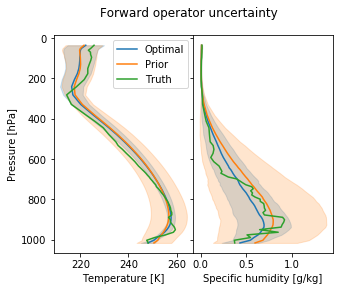

In [202]:
oe_b = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    x_cov.sel(season='DJF').to_pandas(),
    y_vars,
    y_obs,
    y_cov+Syb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_b.doRetrieval()
plotResults(oe_b, h=pressure/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(splitTQ(oe_b.x_op), splitTQ(oe_b.x_truth))])
print(oe_b.chiSquareTest()[0])


# Plot degrees of freedom. 

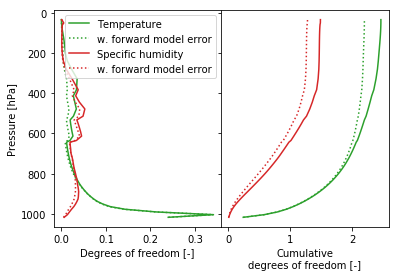

In [165]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)


T, Q = [(x) for x in splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [(x) for x in splitTQ(oe_b.dgf_x)]


ax1.plot(T, pressure/100, color='C2', label= 'Temperature')
ax1.plot(T_e, pressure/100, color='C2', ls=':', label= 'w. forward model error')


ax1.plot(Q, pressure/100, color='C3', label= 'Specific humidity')
ax1.plot(Q_e, pressure/100, color='C3', ls=':', label= 'w. forward model error')


T, Q = [np.cumsum(x) for x in splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [np.cumsum(x) for x in splitTQ(oe_b.dgf_x)]

ax2.plot(T, pressure/100, color='C2', label= 'Temperature')
ax2.plot(T_e, pressure/100, color='C2', ls=':', label= 'w. forward model error')



ax2.plot(Q, pressure/100, color='C3', label= 'Specific humidity')
ax2.plot(Q_e, pressure/100, color='C3', ls=':', label= 'w. forward model error')



ax1.legend()
ax2.set_xlabel('Cumulative\ndegrees of freedom [-]')
ax1.set_xlabel('Degrees of freedom [-]')

ax1.set_ylabel('Pressure [hPa]')
ax1.invert_yaxis()    

fig.subplots_adjust(wspace=0)

In [209]:
oe_sum.linearityTest()

(array([8.70434739e-03, 1.03795637e-04, 1.40731701e-03, 1.54069180e-03,
        2.30133877e-05, 2.87513371e-04, 4.12478176e-05, 1.77146091e-03,
        4.22054978e-03, 3.68241107e-03, 8.74429237e-03, 6.55786642e-03,
        1.94342465e-03, 1.14987235e-04, 1.77824994e-05, 3.67842143e-03,
        1.52449709e-02, 4.46486369e-02, 1.81228402e-05, 5.67729976e-02,
        1.58229435e-01, 3.51600959e-03, 1.49432554e-03, 4.04457414e-05,
        7.61715072e-03, 1.74781468e-03, 4.69830611e-02, 3.00446991e-06,
        2.21632936e-04, 1.89038385e-03, 1.49497669e-04, 8.80935301e-04,
        4.31138351e-06, 2.41566667e-03, 2.03581617e-03, 7.32771924e-04,
        2.15732625e-04, 1.65367428e-06, 1.86767739e-02, 1.35600227e-04,
        1.15512245e-03, 3.50801403e-04, 1.93645263e-04, 2.06921139e-04,
        3.00805431e-05, 2.59351507e-05, 9.73581470e-05, 1.54756479e-04,
        9.71621738e-05, 1.12159119e-04, 1.69477691e-04, 2.10778279e-04,
        2.12360589e-03, 3.54855483e-04, 3.13760508e-05, 7.665811